# **Pytorch MLP Practice**

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from torchvision import datasets, transforms
import torch
import torch.nn as nn
import torch.optim as optim

from torch.utils.data import Dataset, DataLoader

## Importando os dados

In [3]:
from torchvision import datasets, transforms

transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5, ), (0.5,))]) #only one number because we'll be working with only one color, not the RGB

In [14]:
#Dowloading train and test datasets
train_set = datasets.FashionMNIST('~/.pytorch/F_MNIST_data/', download=True, train=True, transform=transform)
test_set = datasets.FashionMNIST('~/.pytorch/F_MNIST_data/', download=True, train=False, transform=transform)

In [15]:
# creating data loader
train_loader = torch.utils.data.DataLoader(train_set, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=64, shuffle=True)  

In [16]:
print("train data: ", len(train_loader))
print("test data: ", len(test_loader))

train data:  938
test data:  157


In [17]:
# examining data
dataiter = iter(train_loader)
images, labels = dataiter.next()

print(type(images))
print(images.shape)
print(labels.shape)

<class 'torch.Tensor'>
torch.Size([64, 1, 28, 28])
torch.Size([64])


In [18]:
#that show us we're working with a Tensor
# of 64 batches, 1 channel and 28x28 pixels images

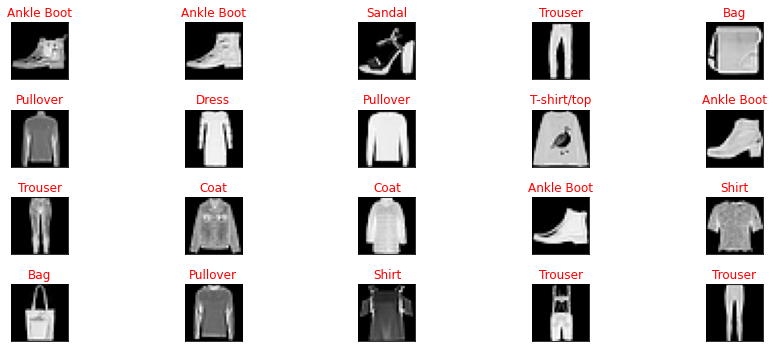

In [9]:
#visualizing images

import matplotlib.pyplot as plt
%matplotlib inline

fig = plt.figure(figsize = (15,5))
rows = 4 
columns = 5 


fashion_classes = { 0 : 'T-shirt/top' ,
                    1 : 'Trouser',
                    2 : 'Pullover',
                    3 : 'Dress',
                    4 :'Coat',
                    5 : 'Sandal',
                    6 : 'Shirt',
                    7 : 'Sneaker',
                    8 : 'Bag',
                    9 : 'Ankle Boot'}


for idx in np.arange(20):
    ax = fig.add_subplot(rows  , columns , idx + 1, xticks = [], yticks = [])
    ax.imshow(images[idx].numpy().squeeze(), cmap ='gray')
    ax.set_title( fashion_classes[labels[idx].item()], color='red' )
    fig.tight_layout()

## Model

In [19]:
from torch import nn, optim
import torch.nn.functional as F

class Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(784,256)
        self.fc2 = nn.Linear(256,128)
        self.fc3 = nn.Linear(128,64)
        self.fc4 = nn.Linear(64,10)
        
    def forward(self,x):
        x = x.view(x.shape[0],-1) # flattening
        
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.log_softmax(self.fc4(x), dim=1)
        
        return x

In [20]:
model = Model()

criterion = nn.NLLLoss()
optimizer = optim.SGD(model.parameters(), lr = 0.01) 

In [111]:
print('Using GPU: ', torch.cuda.is_available()) # checking if it's using GPU

Using GPU:  True


## Training

In [21]:
min_validation_loss = np.inf
epochs = 15

model.train()
train_loss_list = [] 
validation_loss_list = []


for epoch in range(epochs):
    model.train()
    running_loss = 0
    validation_loss = 0
    
    
    for images, labels in train_loader:
        optimizer.zero_grad()
        log_probs = model(images)
        loss = criterion(log_probs, labels)
        loss.backward()
        optimizer.step() 
        running_loss += loss.item()*images.size(0)
        
      
    model.eval()
    with torch.no_grad():
        total =0
        correct = 0
        for images, labels in test_loader:
            log_probs = model(images)
            loss = criterion(log_probs, labels)
            validation_loss += loss.item()*images.size(0)
            max_class = torch.argmax(log_probs, dim = 1) # selects class with higher propability
            total += labels.numel()
            correct += sum(max_class == labels).item()
            
        print("Accuracy: {:.2f}%".format(correct / total * 100))

    running_loss = running_loss / len(train_loader.sampler)
    validation_loss = validation_loss / len(test_loader.sampler)
    
    train_loss_list.append(running_loss)
    validation_loss_list.append(validation_loss)
    
    print("Epoch: {}/{}:".format(epoch+1, epochs),
          "Train Loss: {:.6f}..".format(running_loss),
          "Validation Loss: {:.6f}..".format(validation_loss))
         
    if validation_loss <= min_validation_loss:
        print('Previous Validation Loss {} --> New Validation Loss {}. Saving model.'.format(min_validation_loss, validation_loss))
        torch.save(model.state_dict(), 'modelo.pth')
        min_validation_loss = validation_loss
        
    print()

Accuracy: 72.45%
Epoch: 1/15: Train Loss: 1.366303.. Validation Loss: 0.758611..
Previous Validation Loss inf --> New Validation Loss 0.7586106546401977. Saving model.

Accuracy: 78.60%
Epoch: 2/15: Train Loss: 0.633612.. Validation Loss: 0.588295..
Previous Validation Loss 0.7586106546401977 --> New Validation Loss 0.5882948190689087. Saving model.

Accuracy: 79.92%
Epoch: 3/15: Train Loss: 0.523977.. Validation Loss: 0.546330..
Previous Validation Loss 0.5882948190689087 --> New Validation Loss 0.5463295970916748. Saving model.

Accuracy: 81.61%
Epoch: 4/15: Train Loss: 0.475963.. Validation Loss: 0.504824..
Previous Validation Loss 0.5463295970916748 --> New Validation Loss 0.5048241854190827. Saving model.

Accuracy: 80.63%
Epoch: 5/15: Train Loss: 0.445031.. Validation Loss: 0.516887..

Accuracy: 82.89%
Epoch: 6/15: Train Loss: 0.422467.. Validation Loss: 0.471247..
Previous Validation Loss 0.5048241854190827 --> New Validation Loss 0.4712467443466187. Saving model.

Accuracy: 84.

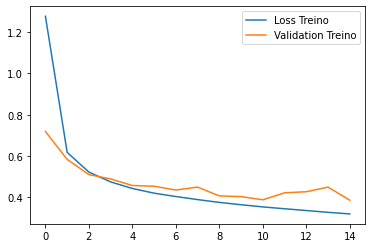

In [13]:
plt.plot(train_loss_list, label = 'Train Loss')
plt.plot(validation_loss_list, label = 'Train Validation')
plt.legend()

## **Checking Results**

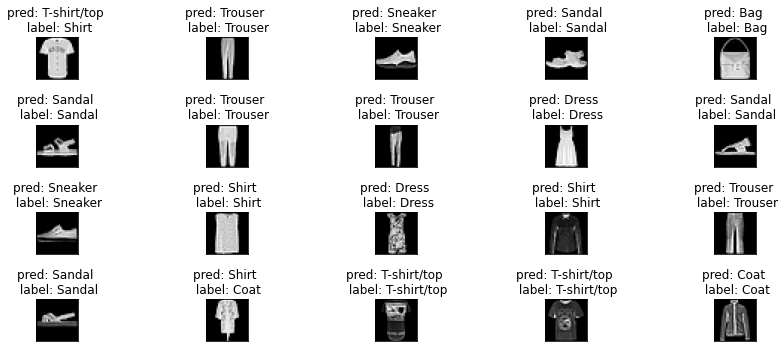

In [24]:
# 1 batch
dataiter = iter(test_loader)
images, labels = dataiter.next()
output = model(images)


fig = plt.figure(figsize = (15,5))
rows = 4 
columns = 5 


_ , predictions = torch.max(output, 1)
images = images.numpy()

for idx in np.arange(20):
    ax = fig.add_subplot(rows  , columns , idx + 1, xticks = [], yticks = [])
    ax.imshow(np.squeeze(images[idx]), cmap ='gray')
    ax.set_title('pred: {} \n label: {}'.format(fashion_classes[predictions[idx].item()] , fashion_classes[labels[idx].item() ]))
    fig.tight_layout()